# DL0ABT IARU Region 1 FD SSB

Es handelt sich hier um eine Auswertung der QSOs von DL0ABT während
der Teilnahme am IARU Region 1 SSB Fieldday am 7-8.9.2019: Op, Bänder, QSO-Raten.

Ich habe es leider nicht geschafft, irgendwelche Auswertungen über Multiplikatoren zu machen.

Es handelt sich um ein [Jupyter](https://jupyter.org/) Notebook (entwickelt und gerendert mit jupyter lab 1.1.3). Außer Jupyter und [Python](https://docs.python.org/3/) habe ich [Matplotlib](https://matplotlib.org/index.html) benutzt. Wer den Sourcecode nicht aus der PDF-Version abtippen will, meldet sich bei [mir](dj3ei@famsik.de).

## Open Source

Copyright © 2019 [DJ3EI](dj3ei@famsik.de)

Dieses Notebook ist freie Software. Sie können es unter den Bedingungen der GNU General Public License, wie von der Free Software Foundation veröffentlicht, weitergeben und/oder modifizieren, entweder gemäß Version 3 der Lizenz oder (wenn Sie das wünschen) jeder späteren Version.

Die Veröffentlichung dieses Notebooks erfolgt in der Hoffnung, daß es Ihnen von Nutzen sein wird, aber OHNE IRGENDEINE GARANTIE, sogar ohne die implizite Garantie der MARKTREIFE oder der VERWENDBARKEIT FÜR EINEN BESTIMMTEN ZWECK. Details finden Sie in der GNU General Public License.

Sie erhalten ein Exemplar der GNU General Public License von <http://www.gnu.org/licenses/>.

## Software importieren

In [1]:
import re
from datetime import timedelta, datetime, timezone
import functools
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt # https://matplotlib.org/contents.html
from matplotlib.dates import DateFormatter



## Adif log einlesen

In [2]:
qsos = []

eoh_re = re.compile('<eoh>', re.IGNORECASE)
field_re = re.compile(r'<((eor)|([\w-]+)\:(\d+))>', re.IGNORECASE)

with open("DL0ABT-ssb-fd-2019-09.adif.adi") as adif_file:
    adif = adif_file.read()
    eoh_mo = eoh_re.search(adif)
    if eoh_mo:
        adif = adif[eoh_mo.end(0):-1]
    qso = {}
    for field_mo in field_re.finditer(adif):
        if field_mo.group(2):
            qsos.append(qso)
            qso = {}
        else:
            field = field_mo.group(3).lower()
            length = int(field_mo.group(4))
            value_start = field_mo.end(0)
            value = adif[value_start:value_start + length]
            qso[field] = value


## QSOs pro Operator

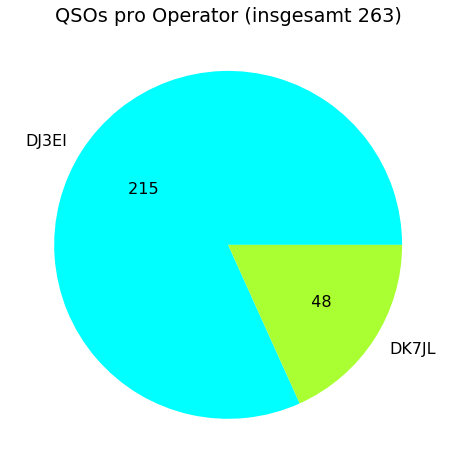

In [3]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'


def filter_by_op(qso):
    return 'DK7JL' if qso['operator'] == 'DL0ABT' else qso['operator']

def plot_by_selection(qsos, select, title, sort_sel=None):
    
    def inc_sel2num(sel2num, qso):
        sel = select(qso)
        sel2num[sel] = sel2num[sel] + 1
        return sel2num

    sel2num = functools.reduce(inc_sel2num, qsos, collections.Counter())
    sels = sorted(sel2num.keys(), key=sort_sel)
    nums = [sel2num[sel] for sel in sels]
    fig, ax = plt.subplots(figsize = [8,8])

    ax.pie(nums, labels = sels, autopct = lambda x: "{:4.0f}".format(x * len(qsos) / 100),
           colors = ['xkcd:cyan', 'xkcd:lime', 'xkcd:baby blue',
                     'xkcd:light pink', 'xkcd:yellow', 'xkcd:light orange' ])
    ax.set_title(title)
    plt.show(block = True)
    return sel2num

title = 'QSOs pro Operator (insgesamt {})'.format(len(qsos))
plot_by_selection(qsos, filter_by_op, title)
pass

Es war auch mal ganz schön, so eine große Station über lange Zeit "für mich" zu haben.
Aber noch mehr hätte mich gefreut, wenn ich nicht über weite Strecken alleine gefunkt hätte,
sondern mehr Op über längere Zeit mitgemacht hätten. DJ3EI

## QSOs pro Band

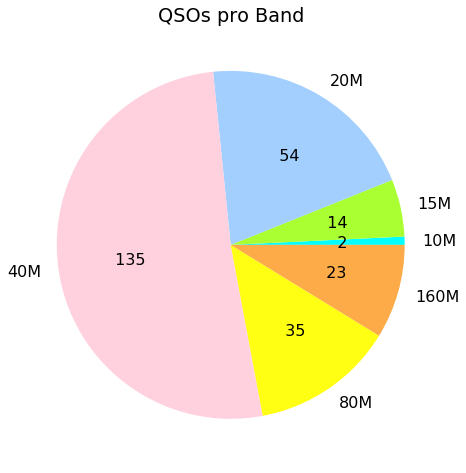

In [4]:
def sort_key_band(band):
    return "0{}".format(band) if len(band) == 3 else band
plot_by_selection(qsos, lambda qso: qso['band'], 'QSOs pro Band', sort_key_band)
pass

## Erreichte Kontinente

Das ist in der Graphik schlecht zu erkennen, deshalb dieselben Daten auch als Tabelle.

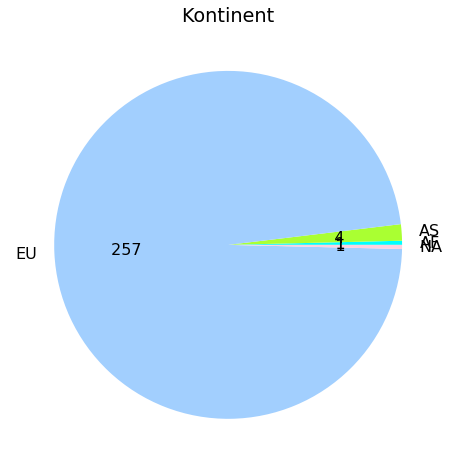

Counter({'AF': 1, 'AS': 4, 'EU': 257, 'NA': 1})

In [5]:
plot_by_selection(qsos, lambda qso: qso['app_n1mm_continent'], 'Kontinent')

## Suchen vs. CQ rufen

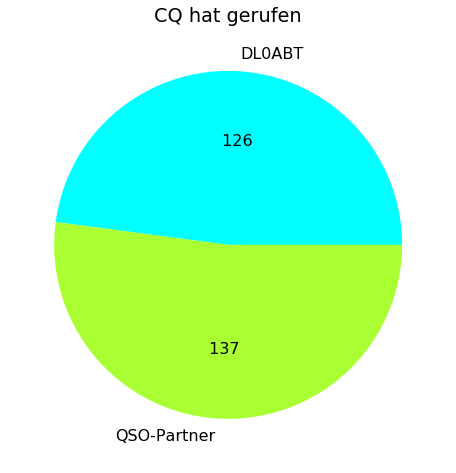

In [6]:
l = len(qsos)
if 2 < l:

    def b2wer(b):
        return 'DL0ABT' if b else 'QSO-Partner'

    qsos[0]['cq'] = b2wer(qsos[0]['freq'] == qsos[1]['freq'])
    qsos[l-1]['cq'] = b2wer(qsos[l-1]['freq'] == qsos[l-2]['freq'])
    for i in range(1, l-1):
        freq = qsos[i]['freq']
        qsos[i]['cq'] = b2wer((qsos[i-1]['freq'] == freq) or (qsos[i+1]['freq'] == freq))
    plot_by_selection(qsos, lambda qso: qso['cq'], 'CQ hat gerufen')

## QSO-Rate

Die QSO-Rate (in QSOs pro Stunde) berechne ich wie folgt: Ein einzelnes QSO erzeugt ein "Signal" bei der QSO-Rate, das einem umgekehrten V gleicht: Ab einer Viertelstunde vorher fängt die QSO-Rate an, linear zu steigen. Zum Zeitpunkt des QSOs erreicht sie den Wert 4. Dann sinkt sie wieder linear ab, genau eine Viertelstunde nach dem QSO ist sie bei Null angekommen.

Diese einzelnen Signale aller QSOs werden aufaddiert. Das ist die unten dargestellte QSO-Raten-Kurve.

### Warum gerade der Wert 4?

Wenn man über lange Zeit regelmäßig jede 15 Minuten ein QSO führt, bleibt die Linie konstant bei 4 stehen. Denn die absteigende Flanke vom letzten QSO und die steigende vom kommenden addieren sich zu einer konstanten Linie der Höhe 4. Wer genau alle Viertelstunde ein QSO macht, macht 4 QSOs pro Stunde.

Allgemeineres Argument: Die Fläche unter der QSO-Raten-Linie (mathematisch: das Integral der QSO-Rate über der Zeit) entspricht genau der Anzahl der QSOs.

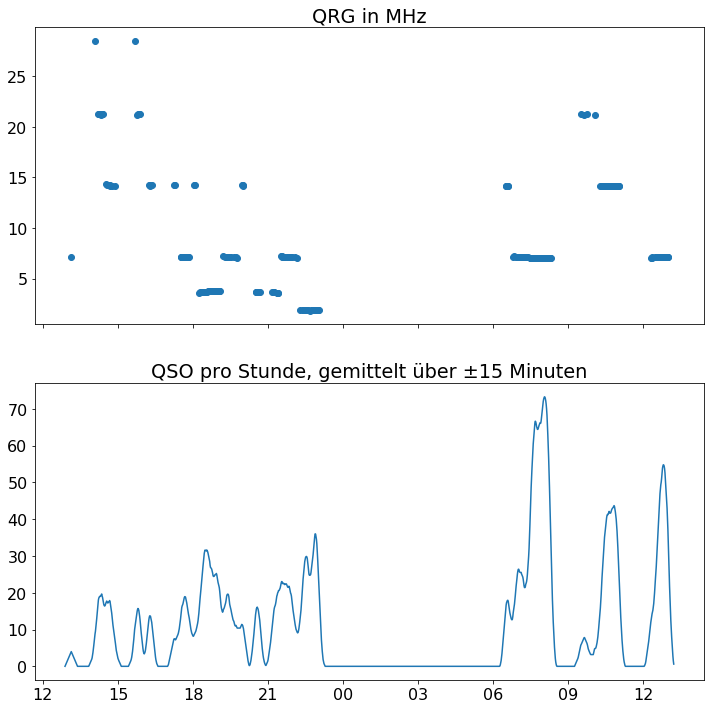

In [7]:

def timeon(qso):
    date = qso['qso_date']
    y = int(date[0:4])
    mo = int(date[4:6])
    d = int(date[6:8])
    time = qso['time_on']
    h = int(time[0:2])
    mi = int(time[2:4])
    s = int(time[4:6])
    return datetime(y, mo, d, h, mi, s, tzinfo = timezone.utc)

qsotimes = [timeon(qso) for qso in qsos]

# Integrating over simple inverted - V function
# spanning +/- 10 minutes.
d = timedelta(minutes=15)
def qsos_per_hour(qsotimes, t):
    start = t - d
    end = t + d
    def nearness_to_t(time):
        if time <= start:
            return 0.0
        elif end <= time:
            return 0.0
        else:
            return (1.0 - (abs(t-time) / d)) * 4.0
    return functools.reduce(lambda x, t_qso: x + nearness_to_t(t_qso), qsotimes, 0.0)

step = timedelta(minutes=1)
overall_start = qsotimes[0] - d
overall_end = qsotimes[len(qsotimes) - 1] + d
ts = [overall_start + i * step for i in range(0, int((overall_end - overall_start)/step))]
# This is incredibly inefficient:
rates = [qsos_per_hour(qsotimes, t) for t in ts]

# As a test, a crude integration:
# print("total: {}".format(functools.reduce(lambda x, r: x + r, rates, 0.0)/60.0))

fig, axs = plt.subplots(nrows = 2, figsize = [12,12], sharex = 'col')
ax = axs[1]
ax.set_title("QSO pro Stunde, gemittelt über ±15 Minuten")
ax.plot_date(ts, rates, '-', xdate = True, ydate = False)
axs[0].set_title("QRG in MHz")
axs[0].plot_date(qsotimes, [float(qso['freq']) for qso in qsos], 'o', xdate = True, ydate = False)
ax.xaxis.set_major_formatter(DateFormatter('%H'))
plt.show(block = True)
pass